In [1]:
%matplotlib inline 
import numpy as np 
from matplotlib import pyplot as plt 
import h5py # used in the Data Visualization section 

from astropy.io import fits,ascii,votable
from astropy import units as u 
from astropy import constants as const
from astropy.table import Table
from astropy.cosmology import Planck15 as cosmo
plt.style.use('../../cooper-paper.mplstyle')

In [2]:
# Specify the version of the catalog and the folder with the input/output files
catversion = 'Farmer'  # this string can be either 'Classic' or 'Farmer'
dir_in = '/Users/oc4858/Box/cosmos/'  
#dir_out = './'  # the directory where the output of this notebook will be stored
fitversion = 'lp'  
# Which type of photometric estimates to use? (suffix of the column name)
# This choice must be consistent with `catversion`,
# choices for Classic are: '_FLUX_APER2', '_FLUX_APER3', '_MAG_APER2,', '_MAG_APER3'
# choices for Farmer are '_FLUX' or '_MAG' 
flx = '_FLUX'  
flxerr = '_FLUXERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'cgs' # 'cgs' or 'uJy'
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']  
filt_lambda = [0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
# corresponding MW attenuation from Schelgel 
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
zpoff1 = [0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,-0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,-0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,-0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],[zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}

In [3]:
# Upload the main catalogue
cat0 = Table.read(dir_in+'COSMOS2020_{}_R1_v2.0.fits'.format(catversion.upper()),format='fits',hdu=1)

In [4]:
notes = Table.read('../wmmc01/cooper_notes_wmmc01.csv',format='csv')
notes

FileNotFoundError: [Errno 2] No such file or directory: '../wmmc01/cooper_notes_wmmc01.csv'

In [54]:
idx = 15
obj_name = notes['obj'][idx]; zguess = float(notes['zmeasured'][idx]); lguess = float(notes['wave'][idx])
print('working on object',obj_name,'with zguess = ',zguess,'at lambda = ',lguess,'AA')

working on object c2020_pz_4.75_29.2_438402 with zguess =  nan at lambda =  nan AA


/var/folders/pg/yy4jmlqx6jdd_b30vyvvg93h0000gq/T/ipykernel_42938/864552941.py:2: UserWarning: Warning: converting a masked element to nan.
  obj_name = notes['obj'][idx]; zguess = float(notes['zmeasured'][idx]); lguess = float(notes['wave'][idx])


In [5]:
#obj = int(obj_name[19:])
targ = cat0[cat0['ID']==766559]

In [6]:
targ

ID,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,N_GROUP,FLAG_HSC,FLAG_SUPCAM,FLAG_UDEEP,FLAG_UVISTA,FLAG_COMBINED,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,CFHT_ustar_MAG,CFHT_ustar_MAGERR,CFHT_ustar_CHISQ,CFHT_ustar_DRIFT,CFHT_ustar_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_y_FLUX,HSC_y_FLUXERR,HSC_y_MAG,HSC_y_MAGERR,HSC_y_CHISQ,HSC_y_DRIFT,HSC_y_VALID,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_Y_MAG,UVISTA_Y_MAGERR,UVISTA_Y_CHISQ,UVISTA_Y_DRIFT,UVISTA_Y_VALID,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_J_MAG,UVISTA_J_MAGERR,UVISTA_J_CHISQ,UVISTA_J_DRIFT,UVISTA_J_VALID,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_H_MAG,UVISTA_H_MAGERR,UVISTA_H_CHISQ,UVISTA_H_DRIFT,UVISTA_H_VALID,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,UVISTA_Ks_MAG,UVISTA_Ks_MAGERR,UVISTA_Ks_CHISQ,UVISTA_Ks_DRIFT,UVISTA_Ks_VALID,UVISTA_NB118_FLUX,UVISTA_NB118_FLUXERR,UVISTA_NB118_MAG,UVISTA_NB118_MAGERR,UVISTA_NB118_CHISQ,UVISTA_NB118_DRIFT,UVISTA_NB118_VALID,SC_IB427_FLUX,SC_IB427_FLUXERR,SC_IB427_MAG,SC_IB427_MAGERR,SC_IB427_CHISQ,SC_IB427_DRIFT,SC_IB427_VALID,SC_IB464_FLUX,SC_IB464_FLUXERR,SC_IB464_MAG,SC_IB464_MAGERR,SC_IB464_CHISQ,SC_IB464_DRIFT,SC_IB464_VALID,SC_IA484_FLUX,SC_IA484_FLUXERR,SC_IA484_MAG,SC_IA484_MAGERR,SC_IA484_CHISQ,SC_IA484_DRIFT,SC_IA484_VALID,SC_IB505_FLUX,SC_IB505_FLUXERR,SC_IB505_MAG,SC_IB505_MAGERR,SC_IB505_CHISQ,SC_IB505_DRIFT,SC_IB505_VALID,SC_IA527_FLUX,SC_IA527_FLUXERR,SC_IA527_MAG,SC_IA527_MAGERR,SC_IA527_CHISQ,SC_IA527_DRIFT,SC_IA527_VALID,SC_IB574_FLUX,SC_IB574_FLUXERR,SC_IB574_MAG,SC_IB574_MAGERR,SC_IB574_CHISQ,SC_IB574_DRIFT,SC_IB574_VALID,SC_IA624_FLUX,SC_IA624_FLUXERR,SC_IA624_MAG,SC_IA624_MAGERR,SC_IA624_CHISQ,SC_IA624_DRIFT,SC_IA624_VALID,SC_IA679_FLUX,SC_IA679_FLUXERR,SC_IA679_MAG,SC_IA679_MAGERR,SC_IA679_CHISQ,SC_IA679_DRIFT,SC_IA679_VALID,SC_IB709_FLUX,SC_IB709_FLUXERR,SC_IB709_MAG,SC_IB709_MAGERR,SC_IB709_CHISQ,SC_IB709_DRIFT,SC_IB709_VALID,SC_IA738_FLUX,SC_IA738_FLUXERR,SC_IA738_MAG,SC_IA738_MAGERR,SC_IA738_CHISQ,SC_IA738_DRIFT,SC_IA738_VALID,SC_IA767_FLUX,SC_IA767_FLUXERR,SC_IA767_MAG,SC_IA767_MAGERR,SC_IA767_CHISQ,SC_IA767_DRIFT,SC_IA767_VALID,SC_IB827_FLUX,SC_IB827_FLUXERR,SC_IB827_MAG,SC_IB827_MAGERR,SC_IB827_CHISQ,SC_IB827_DRIFT,SC_IB827_VALID,SC_NB711_FLUX,SC_NB711_FLUXERR,SC_NB711_MAG,SC_NB711_MAGERR,SC_NB711_CHISQ,SC_NB711_DRIFT,SC_NB711_VALID,SC_NB816_FLUX,SC_NB816_FLUXERR,SC_NB816_MAG,SC_NB816_MAGERR,SC_NB816_CHISQ,SC_NB816_DRIFT,SC_NB816_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH3_MAG,IRAC_CH3_MAGERR,IRAC_CH3_CHISQ,IRAC_CH3_DRIFT,IRAC_CH3_VALID,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,IRAC_CH4_MAG,IRAC_CH4_MAGERR,IRAC_CH4_CHISQ,IRAC_CH4_DRIFT,IRAC_CH4_VALID,VALID_SOURCE,SOLUTION_MODEL,ID_GALEX,GALEX_NUV_FLUX,GALEX_NUV_FLUXERR,GALEX_NUV_MAG,GALEX_NUV_MAGERR,GALEX_FUV_FLUX,GALEX_FUV_FLUXERR,GALEX_FUV_MAG,GALEX_FUV_MAGERR,ID_COSMOS2015,SPLASH_CH1_FLUX,SPLASH_CH1_FLUXERR,SPLASH_CH1_MAG,SPLASH_CH1_MAGERR,SPLASH_CH2_FLUX,SPLASH_CH2_FLUXERR,SPLASH_CH2_MAG,SPLASH_CH2_MAGERR,SPLASH_CH3_FLUX,SPLASH_CH3_FLUXERR,SPLASH_CH3_MAG,SPLASH_CH3_MAGERR,SPLASH_CH4_FLUX,SPLASH_CH4_FLUXERR,SPLASH_CH4_MAG,SPLASH_CH4_MAGERR,ID_ACS,F814W_MAG,F814W_MAGERR,F814W_FLUX,F814W_FLUXERR,ACS_A_WORLD,ACS_B_WORLD,ACS_THETA_WORLD,ACS_FWHM_WORLD,ACS_MU_MAX,ACS_MU_CLASS,ID_CHANDRA,ID_CLASSIC,lp_zBEST,lp_type,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp_chiq,lp_modq,lp_mods,l

In [56]:
print(targ['lp_zBEST'])
print('')
print(targ['lp_MFUV'])

lp_zBEST
--------
   4.753

 lp_MFUV 
   mag   
---------
-19.03714


In [57]:
MUV = targ['UVISTA_J_MAG']-cosmo.distmod(zguess)+(2.5*np.log10(1+zguess))

print("check phot MUV: ",targ['UVISTA_J_MAG']-cosmo.distmod(targ['lp_zBEST'])+(2.5*np.log10(1+targ['lp_zBEST'])))
print("")
print("spec MUV: ",MUV)

check phot MUV:      UVISTA_J_MAG   
        mag        
-------------------
-17.198904248146277

spec MUV:  UVISTA_J_MAG
    mag     
------------
         nan


In [58]:
pdfcat = fits.open(dir_in+'COSMOS2020_FARMER_R1_v2.0_LEPHARE_PZ.fits')

In [59]:
zpdf = pdfcat[0].data[obj]

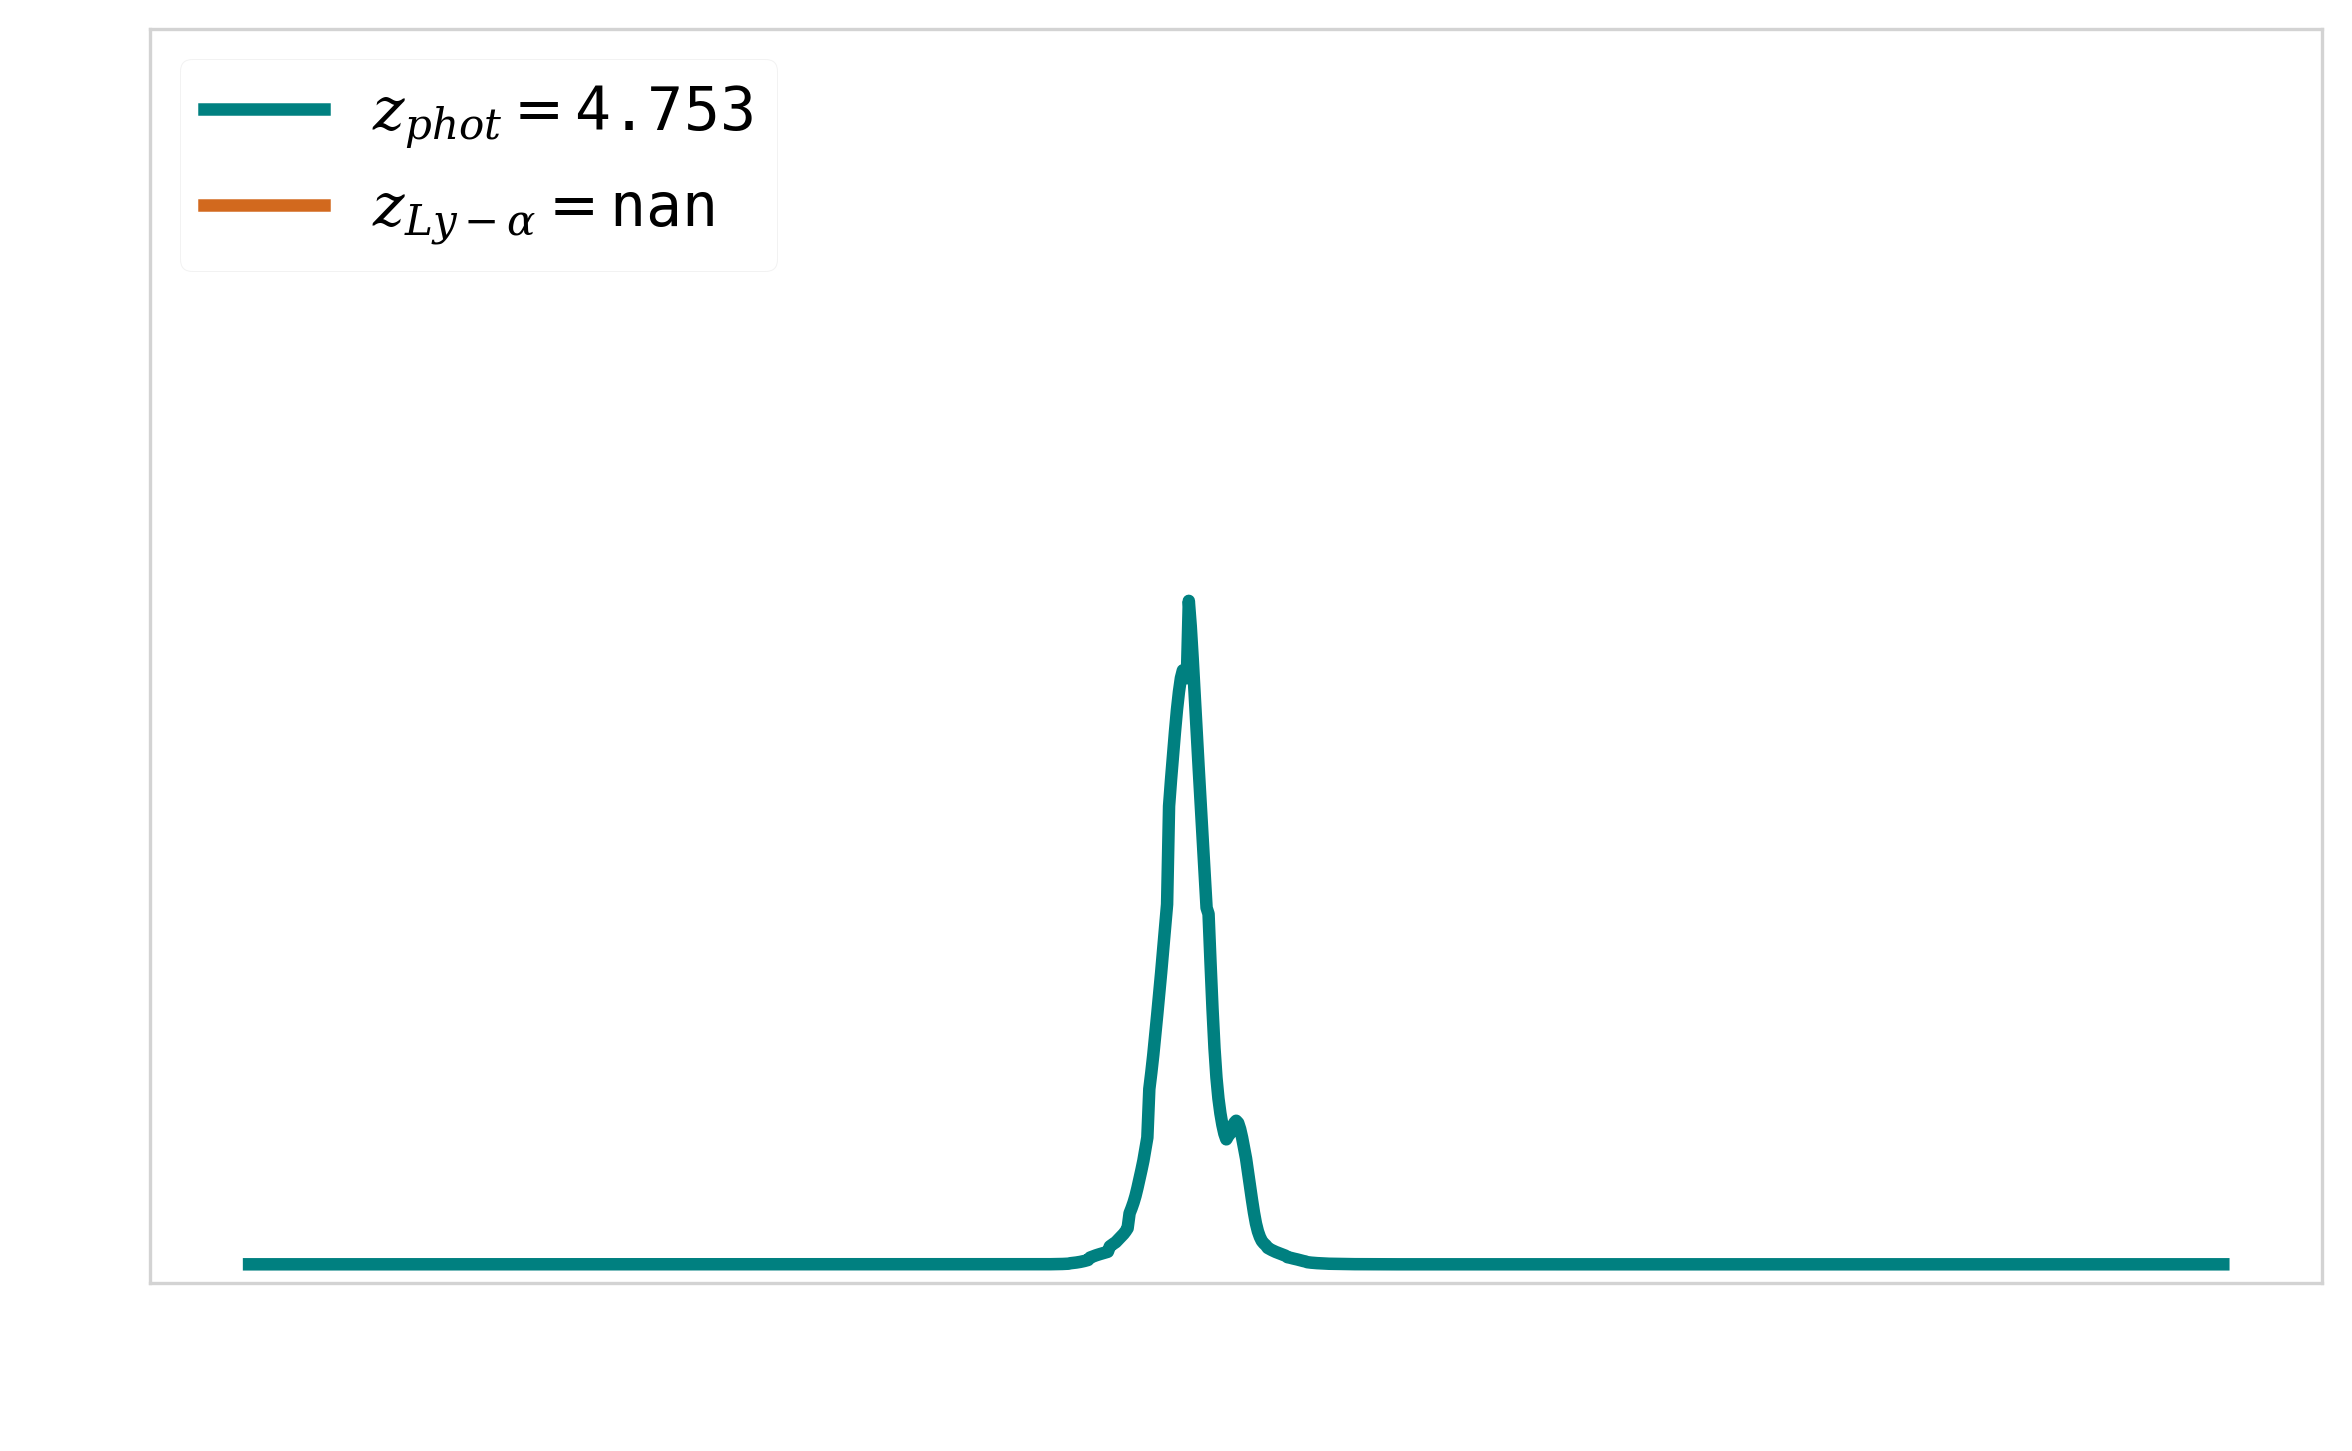

In [60]:
plt.figure(figsize=(8.,5))
zarr = np.linspace(0,10,num=len(zpdf[1:]))
plt.plot(zarr,zpdf[1:],c='teal',lw=3,label=r'$z_{phot}=$'+str(targ['lp_zBEST'][0]))
plt.axvline(zguess,c='chocolate',lw=3,label=r'$z_{Ly-\alpha}=$'+str(zguess))
plt.xlabel('Redshift')
plt.ylabel('LePhare PDF')
#plt.xlim(6.,7.5)
plt.ylim(-0.1,6.7)
plt.legend(fontsize='large',loc='upper left')
plt.grid(False)
plt.show()